### Generate Input Data
* Defines the function used for data points

<IPython.core.display.Javascript object>


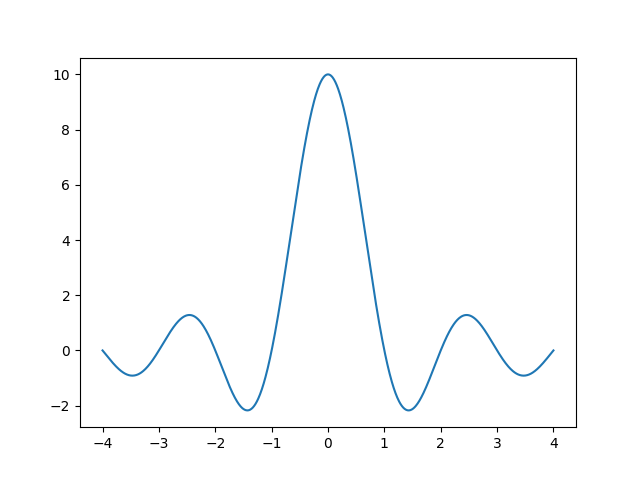

In [42]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

# --- set problem input parameters here ---
Dmin           = -4.
Dmax           = 4.
n_data_pts        = 1000
scale          = 10
EPS = 1e-16
curve = 'sinc'#sinc|sinh
# ------------------------------------------
def get_function_values(x_vals):
    if curve == 'sinc':
        y_vals = scale * np.sinc(x_vals)
    if curve == 'sinh':
        y_vals = 1./scale * np.sinh(x_vals)
    return y_vals

x = np.linspace(Dmin, Dmax, n_data_pts)
y = get_function_values(x)
yRange = y.max()-y.min()
plt.figure()
plt.plot(x, y)

### Helper Functions
* All the function used are in this cell. 
* Ex: Basis functions, constructing matrices, getting data points, decoding curves given control pts, etc.

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import comb
import warnings

# Bezier Curves
def BernsteinBasis(n,j,t): 
    return comb(n,j)*(t**j)*((1-t)**(n-j))

def BernsteinMatrix (n,m):
    t = np.linspace(0,1,m)
    B = np.zeros((2*m,2*n))
    for j in range(0,n):
        b = BernsteinBasis(n-1,j,t)
        for i in range(0,m):
            B[i][j] = b[i]
            B[m+i][n+j] = b[i]
    return B

def Bernstein_Matrix (n,m):
    t = np.linspace(0,1,m)
    B = np.zeros((m,n))
    for j in range(0,n):
        b = BernsteinBasis(n-1,j,t)
        for i in range(0,m):
            B[i][j] = b[i]
    return B

def bezier_curve(Px, Py, n, t_steps):
    t = np.linspace(0.0, 1.0, t_steps)
    bernstein_1d = Bernstein_Matrix(n,t_steps)
    xvals = np.matmul(bernstein_1d,Px)
    yvals = np.matmul(bernstein_1d,Py)
    return xvals, yvals
    


#NURBS curves
def NURBSbasis(u,p,T): 
    return ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else \
            ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * NURBSbasis(u,p-1,T)[:-1] + \
            ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * NURBSbasis(u,p-1,T)[1:]

def get_knot_vector(p,n):
    n_T = p + n + 1
    T = np.linspace(0,1,n_T-2*(p))
    T = np.append(T,np.ones(p))
    T = np.insert(T,0,np.zeros(p))
    return T

def NURBS_Matrix(W, p, T, t_steps):
    U = np.linspace(0,1,t_steps)
    N = NURBSbasis(U[np.newaxis,:],p,T[:,np.newaxis]).T
    return (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])

def NURBS_curve(P, W, p, T, t_steps):
    t = np.linspace(0.0, 1.0, t_steps)
    NURBS_1d = NURBS_Matrix(W,p,T,t_steps)
    nurbs_vals = np.matmul(NURBS_1d,P)

    return nurbs_vals

# Given a knot vector, return the x-coords of the control pts
def get_ctrl_x_vals(knots, p, Dmin, Dmax):
    n_ctrl_points = len(knots) - 1 - p
    cx       = np.zeros(n_ctrl_points)
    for i in range(n_ctrl_points):
        tsum = 0
        for j in range(1, p + 1):
            tsum += knots[i + j]
        cx[i] = float(tsum) / p
    return cx*(Dmax - Dmin) + Dmin


#Function that updates the total number of data pts used
# so that they divide evenly for the number of patches and 
# then returns the number of data pts per patch
def get_n_points_per_patch(n_points,n_patch):
    total_points = (n_points+(n_patch-1))
    diff = total_points%n_patch
    if diff:
        n_points = n_points + (n_patch-diff)
        total_points = (n_points+(n_patch-1))
        diff = total_points%n_patch
    return total_points/n_patch

#Gets x,y data for each patch
def get_x_y_points_global(Dmax, Dmin, n_patch, n_points_patch):
    x_on_patch = np.zeros((n_patch,n_points_patch))
    y_on_patch = np.zeros((n_patch,n_points_patch))
    for k in range(n_patch):
        pts = get_x_y_points_local(Dmax, Dmin, k, n_patch, n_points_patch)
        x_on_patch[k] = pts[0]
        y_on_patch[k] = pts[1]
    return x_on_patch, y_on_patch
def get_x_y_points_local(Dmax, Dmin, k, n_patch, n_points_patch):
    domain_sizes = (Dmax-Dmin)/float(n_patch)
            
    start = k*domain_sizes + Dmin
    end = start + domain_sizes
    
    x_k = np.linspace(start,end,n_points_patch)
    y_k = get_function_values(x_k)
    return x_k, y_k


#Return x,y data points for on interval that overlap a given 
# percentage of the neighboring patches
def get_x_y_points_with_overlap(k, overlap_pct, Dmax, Dmin, \
                                n_patch, n_pts_patch):
    if overlap_pct>=0.5:
        warnings.warn('Not sure what happens past this point.....')
        
    domain_size = (Dmax-Dmin)/float(n_patch)
    pt_increment = domain_size/float(n_pts_per_patch-1)
    
    overlap_n_pts = math.floor(overlap_pct*(n_pts_patch))
    overlap_dist = overlap_n_pts*pt_increment
    
    start = k*domain_size + Dmin
    end = start + domain_size      
    if k==0:
        x = np.linspace(start,end+overlap_dist,n_pts_patch+overlap_n_pts)
    elif k==n_patch-1:
        x = np.linspace(start-overlap_dist,end,n_pts_patch+overlap_n_pts)
    else:
        x = np.linspace(start-overlap_dist,end+overlap_dist,n_pts_patch+2*overlap_n_pts)
    y = get_function_values(x)
    return x,y,overlap_n_pts      


#This function defines the blending function used between two overlaping
# NURBS curves. Its the polynomial Smoothstep function for n=2 (see Wikipedia)
def smooth_function(t):
    out = np.zeros(t.shape[0])
    for i in range(t.shape[0]):
        if abs(t[i])<EPS:
            out[i] = 1.
        elif abs(1.-t[i])<EPS: 
            out[i] = 0.
        else:
            out[i] = 1-(6*(t[i]**5)-15*(t[i]**4)+10*(t[i]**3))
            #out[i] = 1-(3*(t[i]**2) - 2*(t[i]**3))
            #out[i] = 1-t[i]
    return out

#Given two curves over the same domain, fuse them together
def fuse_curves(x,left,right):
    t = (x - x[0])/(x[-1]-x[0]) #scale to [0,1] 
    new_curve = left*smooth_function(t) + right*(1-smooth_function(t))
    return new_curve
        


# Functions for the LaGrange Multiplier method
# Create the B matrix which describes the constraint 
#              pi - pj = 0
def create_B_interface_matrix(n_patch,n): #n is number of control points per patch
    n_intersect = n_patch -1 #special for 1d case
    B = np.zeros((n_intersect,n*n_patch))
    for i in range(n_intersect):
        B[i][i*n+(n-1)] = 1.0 #last control pt in patch i
        B[i][i*n+n] = -1.0 #first control pt in patch i+1
    return B

# Create the entire saddle point system
def create_saddlept_system (R,B,y_on_patch,n,n_patch): #n is number of control points per patch
    n_intersect = n_patch-1 #special for 1d case
    RtR_1_patch = np.matmul(R.T,R)
    RtR = np.zeros((n*n_patch,n*n_patch))
    for i in range(RtR_1_patch.shape[0]):
        for j in range(RtR_1_patch.shape[1]):
            for k in range(n_patch):
                RtR[k*n + i][k*n + j] = 2*RtR_1_patch[i][j]  #we actually need 2*RtR
    zero_mat = np.zeros((n_intersect,n_intersect))
    LHS = np.block([[RtR,      B.T],
                    [  B, zero_mat]])
    Rty = np.array([])
    for k in range(n_patch):
        Rty_on_patch = np.matmul(R.T,y_on_patch[k])
        Rty = np.append(Rty, Rty_on_patch)
    Rty = 2*Rty #we actually need 2*Rty
    zero_vec = np.zeros(n_intersect)
    RHS = np.block([Rty, zero_vec])
    return LHS, RHS


#Computing error of NURBS curve against data
def NURBSError(NURBSCurve,y):
    return np.absolute(NURBSCurve - y)
def SSE(NURBSCurve,y):
    return np.sum(NURBSError(NURBSCurve,y)**2)
def MaxError(NURBSCurve,y):
    return np.amax(NURBSError(NURBSCurve, y))


### Simple Bezier Curve
* DOESN'T WORK YET
* Goal is to merge two Bezier curves as in Lu2014, Lu2015, Wozney2015 found here: https://bitbucket.org/tpeterka1/mfa/wiki/browse/related-work/not-summarized

In [208]:
print 'WORK IN PROGRESS, DOES NOT RUN WITHOUT ERROR'

n_patches = 2

#degree of patch bezier curves
degree12 = 6
n_ctrl12 = degree12 + 1 #Must be this way

#degree of connected bezier curve
n_ctrl = 2*n_ctrl12-1
degree = n_ctrl - 1

#create bezier patches
n_pts_per_patch, n_data_pts = get_n_points_per_patch(n_data_pts,n_patches)

x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)

B = Bernstein_Matrix_1d(n_ctrl12,n_pts_per_patch)

Px_on_patch = np.zeros((n_patches,n_ctrl12)) 
Py_on_patch = np.zeros((n_patches,n_ctrl12)) 
bezier_curve_x = np.zeros((n_patches,n_pts_per_patch))
bezier_curve_y = np.zeros((n_patches,n_pts_per_patch))
for k in range(n_patches):   
    Px_on_patch[k] = np.linalg.lstsq(B,x_on_patch[k],rcond=None)[0]
    Py_on_patch[k] = np.linalg.lstsq(B,y_on_patch[k],rcond=None)[0]
    
    bezier_curve_x[k] = bezier_curve(Px_on_patch[k],Py_on_patch[k],n_ctrl12,n_pts_per_patch)[0]
    bezier_curve_y[k] = bezier_curve(Px_on_patch[k],Py_on_patch[k],n_ctrl12,n_pts_per_patch)[1]


#create new bezier curve
if True:
    Px_new = np.zeros(n_ctrl)
    Py_new = np.zeros(n_ctrl)
    for i in range(n_ctrl):
        if i<n_ctrl12-1:
            patch = 0
        elif i>n_ctrl12-1:
            patch = 1
        else:
            patch=-1

        if i==0:
            Px_new[i] = Px_on_patch[patch][i]
            Py_new[i] = Py_on_patch[patch][i]
        elif i==n_ctrl-1:
            Px_new[i] = Px_on_patch[patch][n_ctrl12-1]
            Py_new[i] = Py_on_patch[patch][n_ctrl12-1]
        elif patch==0:
            Px_new[i] = 0.5*(Px_on_patch[patch][i] + Px_on_patch[patch][i-1])
            Py_new[i] = 0.5*(Py_on_patch[patch][i] + Py_on_patch[patch][i-1])
        elif patch==1:
            Px_new[i] = 0.5*(Px_on_patch[patch][i-n_ctrl12+1] + Px_on_patch[patch][i-n_ctrl12])
            Py_new[i] = 0.5*(Py_on_patch[patch][i-n_ctrl12+1] + Py_on_patch[patch][i-n_ctrl12])
        elif patch==-1:
            Px_new[i] = 0.5*(Px_on_patch[0][n_ctrl12-1] + Px_on_patch[1][i-(n_ctrl12-1)])
            Py_new[i] = 0.5*(Py_on_patch[0][n_ctrl12-1] + Py_on_patch[1][i-(n_ctrl12-1)])

    new_bez = bezier_curve(Px_new,Py_new,n_ctrl,n_data_pts)
    new_bez_x = new_bez[0]
    new_bez_y = new_bez[1]




plt.figure()
for k in range(n_patches):
    if k == 0:
        label_data = 'Data'
        label_ctrl = 'Ctrl'
        label_bezier = 'Bezier'
    else:
        label_data = ''
        label_ctrl = ''
        label_bezier = ''
    plt.plot(x, y,'b-',label=label_data)
    plt.plot(Px_on_patch[k],Py_on_patch[k],'ro--',label=label_ctrl)
    plt.plot(bezier_curve_x[k],bezier_curve_y[k],'g--',lw=3,label=label_bezier)
plt.plot(Px_new,Py_new,'mo--')
#plt.plot(new_bez_x,new_bez_y,'m--')
plt.legend()
plt.show()
    


WORK IN PROGRESS, DOES NOT RUN WITHOUT ERROR


TypeError: 'int' object is not iterable

### Calculate local NURBS patches without overlap
* Each patch is considered individually
* No overlap
* ***No continuity constraint***

Total number of control points: 20

Max Error ( patch 0 ): 0.189798448747586
SSE: 3.434039797878383


<IPython.core.display.Javascript object>


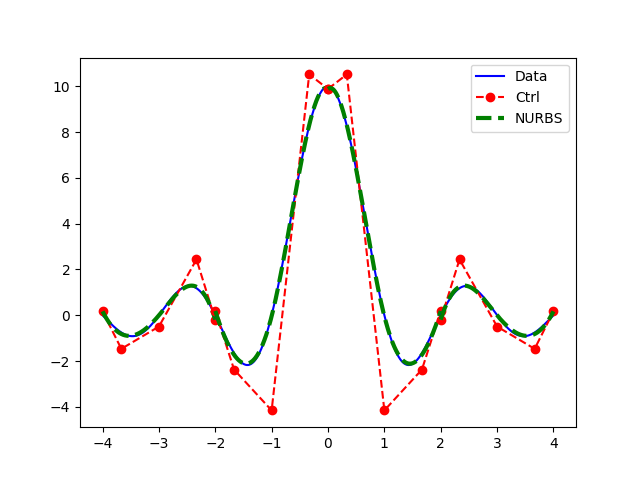

In [206]:
n_patches = 4
n_data_pts = 1000

degree = 3
n_ctrl_pts = degree+2 # Number of control points on each patch

print 'Total number of control points: %i\n'%(n_ctrl_pts*n_patches)


n_pts_per_patch = get_n_points_per_patch(n_data_pts,n_patches)
x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)
    
# Compute NURBS on each patch
knots = get_knot_vector(degree,n_ctrl_pts)
W = np.ones(n_ctrl_pts)
R = NURBS_Matrix(W,degree,knots,n_pts_per_patch)


P = np.zeros((n_patches,n_ctrl_pts)) #control pts for each patch k
x_ctrl_vals = np.zeros((n_patches,n_ctrl_pts))
NURBS = np.zeros((n_patches,n_pts_per_patch)) #NURBS for each patch k
for k in range(n_patches):   
    P[k] = np.linalg.lstsq(R,y_on_patch[k],rcond=None)[0]
    x_ctrl_vals[k] = get_ctrl_x_vals(knots, degree, x_on_patch[k][0], x_on_patch[k][-1])

    NURBS[k] = NURBS_curve(P[k],W,degree,knots,n_pts_per_patch)

    
# Calculate error
max_error = 0
max_error_per_patch = np.zeros(n_patches)
patch_with_max_err = 0
sse = 0
for k in range(n_patches):
    max_error_per_patch[k] = MaxError(NURBS[k],y_on_patch[k]) 
    if max_error < max_error_per_patch[k]:
        max_error = max_error_per_patch[k]
        patch_with_max_err = k
    sse += SSE(NURBS[k],y_on_patch[k])
print 'Max Error ( patch',patch_with_max_err,'):',max_error
#print max_error_per_patch
print 'SSE:',sse


#plot
plt.figure()
for k in range(n_patches):
    if k == 0:
        label_data = 'Data'
        label_ctrl = 'Ctrl'
        label_nurbs = 'NURBS'
    else:
        label_data = ''
        label_ctrl = ''
        label_nurbs = ''
    plt.plot(x_on_patch[k],y_on_patch[k],'b-',label=label_data)
    plt.plot(x_ctrl_vals[k],P[k],'r--o',label = label_ctrl)
    plt.plot(x_on_patch[k],NURBS[k],'g--',lw=3,label=label_nurbs)
plt.legend()
plt.show()


### Multipatch NURBS with Lagrange Multipliers (Global System)
* Create a global system using Lagrange multipliers method
* Exact C0 continuity...but a global system over all patches
* lambda values give a measure of how *important* the constraint is. If lambda=0 it means that the points would be identical even with no continuity constraint

lambda values:  [-4.30988222e+00 -1.21816623e-13  4.30988222e+00]
Max Error ( patch 3 ): 0.19519510350183492
SSE: 5.065571176250159


<IPython.core.display.Javascript object>


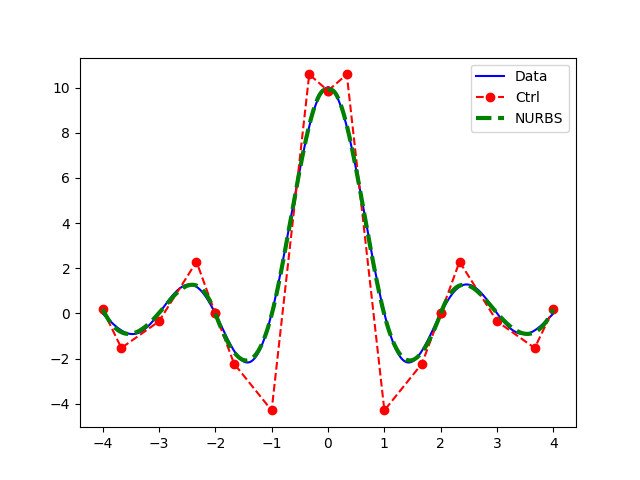

In [205]:
n_patches = 4
n_data_pts = 1000
degree = 3
n_ctrl_pts = degree+2 # Number of control points on each patch

#Number of input data point made to divide equally amoung patch to make easier
n_pts_per_patch = get_n_points_per_patch(n_data_pts,n_patches)
x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)
    
# Compute NURBS on each patch
knots = get_knot_vector(degree,n_ctrl_pts)
W = np.ones(n_ctrl_pts)
R = NURBS_Matrix(W,degree,knots,n_pts_per_patch)

B = create_B_interface_matrix(n_patches,n_ctrl_pts)
A,b = create_saddlept_system(R,B,y_on_patch,n_ctrl_pts,n_patches)
solution = np.linalg.solve(A,b)

lamb = solution[n_ctrl_pts*n_patches:solution.shape[0]]              
print 'lambda values: ',lamb

x_ctrl_vals = np.zeros((n_patches,n_ctrl_pts))
P_on_patch = np.zeros((n_patches,n_ctrl_pts))
NURBS_curve_on_patch = np.zeros((n_patches,n_pts_per_patch))
for k in range(n_patches):
    x_ctrl_vals[k] = \
           get_ctrl_x_vals(knots, degree, x_on_patch[k][0], x_on_patch[k][-1])

    start = k*n_ctrl_pts
    P_on_patch[k] = solution[start:start+n_ctrl_pts]
    
    NURBS_curve_on_patch[k] = NURBS_curve(P_on_patch[k],W,degree,knots,n_pts_per_patch)
        
max_error = 0
max_error_per_patch = np.zeros(n_patches)
patch_with_max_err = 0
sse = 0
for k in range(n_patches):
    max_error_per_patch[k] = MaxError(NURBS_curve_on_patch[k],y_on_patch[k]) 
    if max_error < max_error_per_patch[k]:
        max_error = max_error_per_patch[k]
        patch_with_max_err = k
    sse += SSE(NURBS_curve_on_patch[k],y_on_patch[k])
print 'Max Error ( patch',patch_with_max_err,'):',max_error
#print max_error_per_patch
print 'SSE:',sse
        
    

plt.figure()
for k in range(n_patches):
    if k == 0:
        label_data = 'Data'
        label_ctrl = 'Ctrl'
        label_nurbs = 'NURBS'
    else:
        label_data = ''
        label_ctrl = ''
        label_nurbs = ''
    plt.plot(x_on_patch[k],y_on_patch[k],'b-',label=label_data)
    plt.plot(x_ctrl_vals[k],P_on_patch[k],'r--o',label = label_ctrl)
    plt.plot(x_on_patch[k],NURBS_curve_on_patch[k],'g--',lw=3,label=label_nurbs)
plt.legend()
plt.show()

### Multipatch NURBS with overlap (Local Systems)
* Each domain knows about its own patch and a specified number around it (for example, if *n_overlap=1* then domain (patch) 3 knows about patches 2-4 
* Solve each domain individually with lagrangian multipliers. Note this is not a global system, but perhaps if locally each domain forces C0 continuity between patches, the boundaries of each patch will converge to C0 globally

Domain 0 lambda values:  [-4.30988222]
Domain 1 lambda values:  [-4.32668344 -0.26961737]
Domain 2 lambda values:  [0.26961737 4.32668344]
Domain 3 lambda values:  [4.30988222]
Max Error ( patch 3 ): 0.19519510350183475
SSE: 5.062366283232214


<IPython.core.display.Javascript object>


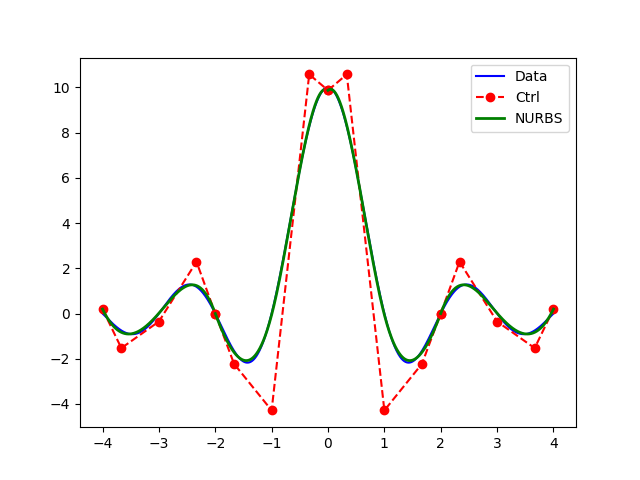

In [204]:
n_patches = 4
n_domains = n_patches

plot_overlap = False #plot each local view seperately

n_data_pts = 1000
degree = 3
n_ctrl_pts = degree+2 # Number of control points on each patc
n_overlap = 1 # how many patches away from your domain do you know about...

#Number of input data point made to divide equally amoung patch to make easier
n_pts_per_patch = get_n_points_per_patch(n_data_pts,n_patches)
x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)
    
# Compute NURBS on each patch
knots = get_knot_vector(degree,n_ctrl_pts)
W = np.ones(n_ctrl_pts)
R = NURBS_Matrix(W,degree,knots,n_pts_per_patch)

max_domain_size = 1+2*n_overlap
max_domain_ctrl_pts = max_domain_size*n_ctrl_pts
max_domain_n_pts = n_pts_per_patch*max_domain_size

total_patch_per_domain = np.zeros(n_domains)

P = np.zeros((n_patches,n_ctrl_pts)) 
x_ctrl_vals = np.zeros((n_patches,n_ctrl_pts))
NURBS = np.zeros((n_patches,n_pts_per_patch))

# Each domain contains its patch and up to 2*n_overlap around it
for d in range(n_domains):
    #Get the patches this domain knows about
    local_patches = np.array([]);
    for i in range(d-n_overlap,d+1+n_overlap):
        if i>=0 and i<n_patches:
            local_patches = np.append(local_patches,i)
    domain_size = int(local_patches.shape[0])
    total_patch_per_domain[d] = domain_size
    
    x_on_domains = np.zeros((domain_size,n_pts_per_patch))
    y_on_domains = np.zeros((domain_size,n_pts_per_patch))
    for i in range(domain_size):
        x_on_domains[i] = x_on_patch[int(local_patches[i])]
        y_on_domains[i] = y_on_patch[int(local_patches[i])]
    
    B = create_B_interface_matrix(domain_size,n_ctrl_pts)
    A,b = create_saddlept_system(R,B,y_on_domains,\
                                 n_ctrl_pts,domain_size)
    solution = np.linalg.solve(A,b)

    lamb = solution[n_ctrl_pts*domain_size:solution.shape[0]]
    print 'Domain',d,'lambda values: ',lamb
        
    # Local control pt values and NURBS values
    P_local = np.zeros((domain_size,n_ctrl_pts))
    x_ctrl_vals_local = np.zeros((domain_size,n_ctrl_pts))
    NURBS_local = np.zeros((domain_size,n_pts_per_patch))
    for k in range(domain_size):
        x_ctrl_vals_local[k] = \
            get_ctrl_x_vals(knots, degree, \
                            x_on_patch[int(local_patches[k])][0], \
                            x_on_patch[int(local_patches[k])][-1])
        start = k*n_ctrl_pts
        P_local[k] = solution[start:start+n_ctrl_pts]
        NURBS_local[k] = NURBS_curve(P_local[k],W,degree,knots,n_pts_per_patch)
        
        # each domain only stores data on its own patch
        if int(local_patches[k])==d:
            P[d] = P_local[k]
            x_ctrl_vals[d] = get_ctrl_x_vals(knots, degree, \
                            x_on_patch[d][0], \
                            x_on_patch[d][-1])
            NURBS[d] = NURBS_local[k]
        
    # plot each individual domain (only if set true)
    if plot_overlap:
        plt.figure()
        for i in range(n_patches):
            plt.plot(x_on_patch[i],y_on_patch[i],'-b')
        for k in range(domain_size):
            plt.plot(x_ctrl_vals_local[k],P_local[k],'ro--')
            plt.plot(x_on_patch[int(local_patches[k])],NURBS_local[k],'g--',lw=3)
        plt.legend()
        plt.show()

#Compute errors
max_error = 0
max_error_per_patch = np.zeros(n_patches)
patch_with_max_err = 0
sse = 0
for k in range(n_patches):
    max_error_per_patch[k] = MaxError(NURBS[k],y_on_patch[k]) 
    if max_error < max_error_per_patch[k]:
        max_error = max_error_per_patch[k]
        patch_with_max_err = k
    sse += SSE(NURBS[k],y_on_patch[k])
print 'Max Error ( patch',patch_with_max_err,'):',max_error
#print max_error_per_patch
print 'SSE:',sse

#plot
plt.figure()
for k in range(n_domains):
    if k == 0:
        label_data = 'Data'
        label_ctrl = 'Ctrl'
        label_nurbs = 'NURBS'
    else:
        label_data = ''
        label_ctrl = ''
        label_nurbs = ''
    plt.plot(x_on_patch[k],y_on_patch[k],'b-',label=label_data)
    plt.plot(x_ctrl_vals[k],P[k],'r--o',label=label_ctrl)
    plt.plot(x_on_patch[k],NURBS[k],'g-',lw=2,label=label_nurbs)

plt.legend()
plt.show()

### Numerical flux reconstruction
* No actual flux reconstruction happening yet
* Only options are: 
1. 'average' which forces C0 continuity by setting the value of each control point on the boundary to the average of the two control pts
2. 'none' which is equivalent to multipatch with no overlap

Total number of control points: 20

Max Error ( patch 2 ): 0.18445988430354388
SSE: 6.065275567906447


<IPython.core.display.Javascript object>


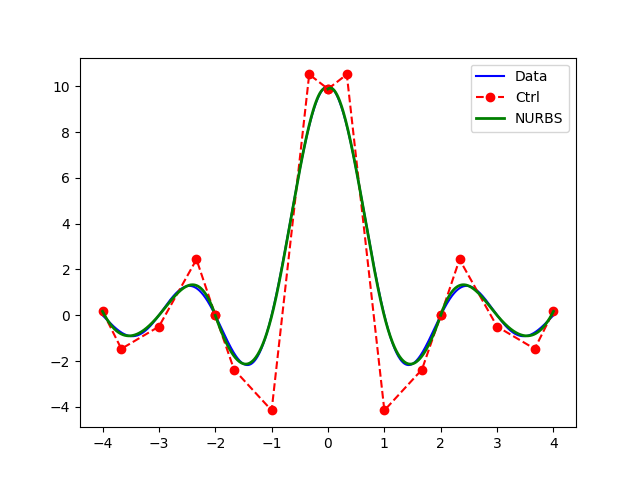

In [202]:
n_patches = 4
n_intersections = n_patches - 1 #Special Case for 1d

n_data_pts = 1000

reconstruct_type = 'average'
#reconstruct_type = 'none'

degree = 3
n_ctrl_pts = degree+2 # Number of control points on each patch
print 'Total number of control points: %i\n'%(n_ctrl_pts*n_patches)

n_pts_per_patch = get_n_points_per_patch(n_data_pts,n_patches)
x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)
    
# Compute NURBS on each patch
knots = get_knot_vector(degree,n_ctrl_pts)
W = np.ones(n_ctrl_pts)
R = NURBS_Matrix(W,degree,knots,n_pts_per_patch)

P = np.zeros((n_patches,n_ctrl_pts))
x_ctrl_vals = np.zeros((n_patches,n_ctrl_pts))
NURBS = np.zeros((n_patches,n_pts_per_patch))
for k in range(n_patches):   
    P[k] = np.linalg.lstsq(R,y_on_patch[k],rcond=None)[0]
    x_ctrl_vals[k] = get_ctrl_x_vals(knots, degree, x_on_patch[k][0], x_on_patch[k][-1])
    
# Enforce continuity
for i in range(n_intersections):
    if reconstruct_type == 'average':
        P[i][-1] = P[i+1][0] =\
                            0.5*(P[i][-1]+P[i+1][0])
    elif reconstruct_type == 'none':
        pass
    
    NURBS[i] = NURBS_curve(P[i],W,degree,knots,n_pts_per_patch)
    NURBS[i+1] = NURBS_curve(P[i+1],W,degree,knots,n_pts_per_patch)


max_error = 0
max_error_per_patch = np.zeros(n_patches)
patch_with_max_err = 0
sse = 0
for k in range(n_patches):
    max_error_per_patch[k] = MaxError(NURBS[k],y_on_patch[k]) 
    if max_error < max_error_per_patch[k]:
        max_error = max_error_per_patch[k]
        patch_with_max_err = k
    sse += SSE(NURBS[k],y_on_patch[k])
print 'Max Error ( patch',patch_with_max_err,'):',max_error
#print max_error_per_patch
print 'SSE:',sse



plt.figure()
for k in range(n_patches):
    if k == 0:
        label_data = 'Data'
        label_ctrl = 'Ctrl'
        label_nurbs = 'NURBS'
    else:
        label_data = ''
        label_ctrl = ''
        label_nurbs = ''
    plt.plot(x_on_patch[k],y_on_patch[k],'b-',label=label_data)
    plt.plot(x_ctrl_vals[k],P[k],'r--o',label = label_ctrl)
    plt.plot(x_on_patch[k],NURBS[k],'g-',lw=2,label=label_nurbs)
plt.legend()
plt.show()

### Percentage Overlap
* Have each patch overlap the surrounding patches by a certain percentage
* Use a blending function in the area of the overlap
* Note: control points no longer line up for each patch

Total number of control points: 20



<IPython.core.display.Javascript object>


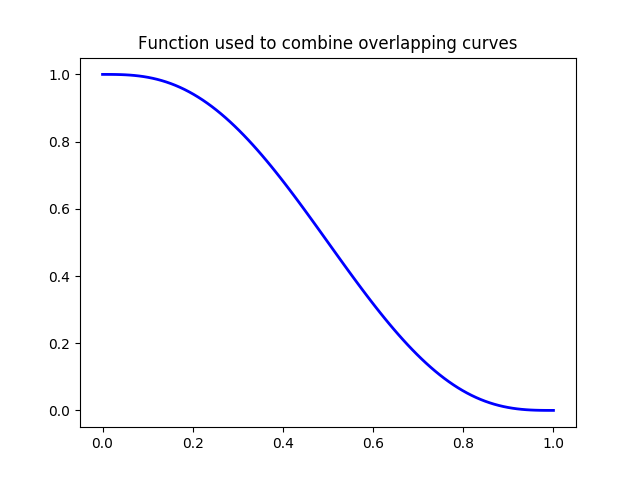

<IPython.core.display.Javascript object>


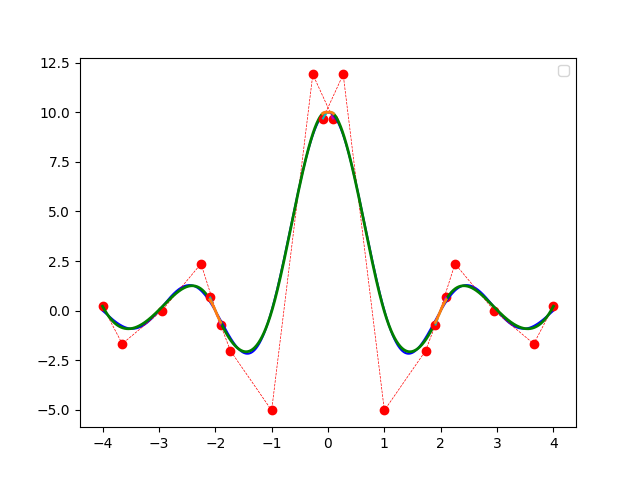


Max Error ( patch 3 ): 0.21943459854383465
SSE: 5.679626879230628


/home/tcclevenger/.local/lib/python2.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/tcclevenger/.local/lib/python2.7/site-packages/ipykernel_launcher.py:125: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/tcclevenger/.local/lib/python2.7/site-packages/ipykernel_launcher.py:123: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [201]:
n_patches = 4
n_intersections = n_patches - 1 #special for 1d domain
n_data_pts = 1000

overlap_pct = 0.05

degree = 3
n_ctrl_pts = degree+2 # Number of control points on each patch

print 'Total number of control points: %i\n'%(n_ctrl_pts*n_patches)

n_pts_per_patch = get_n_points_per_patch(n_data_pts,n_patches)
x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)

#Blending function
t = np.linspace(0,1,100)
blend = smooth_function(t)
plt.figure()
plt.plot(t,blend,'b-',lw=2)
plt.title('Function used to combine overlapping curves')
plt.show()
    
    
    
# Compute NURBS on each patch and error
knots = get_knot_vector(degree,n_ctrl_pts)
W = np.ones(n_ctrl_pts)

max_error = 0
max_error_per_patch = np.zeros(n_patches)
patch_with_max_err = 0
sse = 0

plt.figure()
for k in range(n_patches):  
    x_overlap,y_overlap, overlap_size = \
        get_x_y_points_with_overlap(k, overlap_pct, Dmax, Dmin,\
                                    n_patches, n_pts_per_patch)
    new_n_pts = x_overlap.shape[0]
    
    R = NURBS_Matrix(W,degree,knots,new_n_pts)
    P = np.linalg.lstsq(R,y_overlap,rcond=None)[0]
    x_ctrl_vals = get_ctrl_x_vals(knots, degree, x_overlap[0], x_overlap[-1])
    
    NURBS = NURBS_curve(P,W,degree,knots,new_n_pts)
        
    plt.plot(x_on_patch[k],y_on_patch[k],'b-')
    plt.plot(x_ctrl_vals,P,'r--o',lw=0.5)
    
    # Plot/compute errors on non-overlapping part of the curve
    #     indices of the non overlaping area depend on which patch 
    #     we are on. For example patch k=0 has no overlap at the beginning
    #     but overlap at the end
    start = end = 0
    if k==0:
        start = 0 
        end = int(new_n_pts-2*overlap_size)
    elif k==n_patches-1:
        start = int(2*overlap_size)
        end = int(new_n_pts)
    else:
        start = int(2*overlap_size)
        end = int(new_n_pts-2*overlap_size)
        
    # Error for the non overlaping part of the curve
    max_error_per_patch[k] = MaxError(NURBS[start:end], y_overlap[start:end])
    sse += SSE(NURBS[start:end], y_overlap[start:end])
    if max_error < max_error_per_patch[k]:
        max_error = max_error_per_patch[k]
        patch_with_max_err = k
    
    #plot
    plt.plot(x_overlap[start:end],NURBS[start:end],'g-',lw=2)

# Blending of the left and right curve in the overlap sections
max_error_per_intersection = np.zeros(n_intersections)
for i in range(n_intersections):
    # left
    x_overlap,y_overlap, overlap_size = \
        get_x_y_points_with_overlap(i, overlap_pct, Dmax, Dmin,\
                                    n_patches, n_pts_per_patch)
    new_n_pts = x_overlap.shape[0]
    
    R = NURBS_Matrix(W,degree,knots,new_n_pts)
    P = np.linalg.lstsq(R,y_overlap,rcond=None)[0]
    x_ctrl_vals = get_ctrl_x_vals(knots, degree, x_overlap[0], x_overlap[-1])
    
    start = int(new_n_pts-1-2*overlap_size)
    end = new_n_pts
    left = NURBS_curve(P,W,degree,knots,new_n_pts)[start:end]
    
    # right
    x_overlap,y_overlap, overlap_size = \
        get_x_y_points_with_overlap(i+1, overlap_pct, Dmax, Dmin,\
                                    n_patches, n_pts_per_patch)
    new_n_pts = x_overlap.shape[0]
    
    R = NURBS_Matrix(W,degree,knots,new_n_pts)
    P = np.linalg.lstsq(R,y_overlap,rcond=None)[0]
    x_ctrl_vals = get_ctrl_x_vals(knots, degree, x_overlap[0], x_overlap[-1])

    start = 0
    end = int(2*overlap_size)+1
    right = NURBS_curve(P,W,degree,knots,new_n_pts)[start:end]
    
    # data in the overlapping section
    x_intersect = x_overlap[start:end]
    y_intersect = y_overlap[start:end]
    
    new_curve = fuse_curves(x_intersect,left,right)
    
    max_error_per_intersection[i] = MaxError(new_curve, y_intersect)
    sse += SSE(new_curve,y_intersect)
    if max_error < max_error_per_intersection[i]:
        max_error = max_error_per_intersection[i]
        patch_with_max_err = -1*(i+1)
        
    plt.plot(x_intersect, left,'m--') #left curve
    plt.plot(x_intersect, right,'c--') #right curve
    plt.plot(x_intersect, new_curve, 'C1-',lw=2) #blended curve
        
        
print
print 'Max Error ( patch',patch_with_max_err,'):',max_error
print 'SSE:',sse
    
         
plt.legend()
plt.show()

### 1 buffer patch in between domains
* Define the number of domains to use. This then determines the number of patches. Each domain overlap another domain by exactly 1 patch, and no patch contains more than 2 domains, that is, no individual patch has 3 or more curves  
* Again use a blending function in the patch of the overlap
* Note: control points now will line up for each patch

Total number of control points: 20

Max Error (domain 0): 0.5680723602786408
SSE: 42.42045500583689


<IPython.core.display.Javascript object>


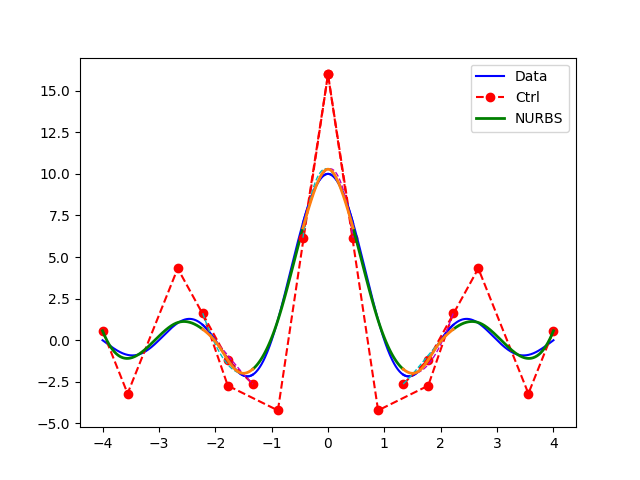

In [207]:
n_domains = 4
domain_size = 3
n_patches = 2*n_domains + 1

n_intersect = n_domains-1

n_data_pts = 1000
degree = 3
n_ctrl_pts = degree+2 # Number of control points on each domain

print 'Total number of control points: %i\n'%(n_ctrl_pts*n_domains)

#Number of input data point made to divide equally among patch to make easier
n_pts_per_patch = get_n_points_per_patch(n_data_pts,n_patches)
n_pts_domain = n_pts_per_patch*domain_size-2

x_on_patch,y_on_patch = get_x_y_points_global(Dmax,Dmin,n_patches,n_pts_per_patch)
x_on_domain = np.zeros((n_domains,n_pts_domain))
y_on_domain = np.zeros((n_domains,n_pts_domain))

#Separate input Data for each domain
for d in range(n_domains):
    x_vals = np.array([])
    y_vals = np.array([])
    for i in range(domain_size):
        if i==0:
            start = 0
            end = n_pts_per_patch
        else:
            start = 1
            end = n_pts_per_patch
        x_vals = np.append(x_vals,x_on_patch[2*d+i][start:end])
        y_vals = np.append(y_vals,y_on_patch[2*d+i][start:end])
    x_on_domain[d] = x_vals
    y_on_domain[d] = y_vals
    
#Knots and Weights and basis matrix  
knots = get_knot_vector(degree,n_ctrl_pts)
W = np.ones(n_ctrl_pts)
R = NURBS_Matrix(W,degree,knots,n_pts_domain)

P = np.zeros((n_domains,n_ctrl_pts)) 
x_ctrl_vals = np.zeros((n_domains,n_ctrl_pts))

x_strictly_domain = np.zeros((n_domains,n_pts_domain-n_pts_per_patch+1))
x_intersect = np.zeros((n_intersect,n_pts_per_patch))
y_strictly_domain = np.zeros((n_domains,n_pts_domain-n_pts_per_patch+1))
y_intersect = np.zeros((n_intersect,n_pts_per_patch))

NURBS_strictly_domain = np.zeros((n_domains,n_pts_domain-n_pts_per_patch+1))
NURBS_intersect = np.zeros((n_intersect,2*n_pts_per_patch))

intersect_curve = np.zeros((n_intersect,n_pts_per_patch))

max_error = 0
max_error_per_domain = np.zeros(n_domains)
max_error_per_intersection = np.zeros(n_intersect)
domain_with_max_err = 0
sse = 0

# Compute NURBS on each domain
for d in range(n_domains):
    #solve for control points
    P[d] = np.linalg.lstsq(R,y_on_domain[d],rcond=None)[0]
    x_ctrl_vals[d] = get_ctrl_x_vals(knots, degree, x_on_domain[d][0], x_on_domain[d][-1])
    #Calculate NURBS over whole domain
    NURBS = NURBS_curve(P[d],W,degree,knots,n_pts_domain)
     
    #find part of NURBS strictly on domain
    if d==0:
        start = 0
        end = 2*n_pts_per_patch-1
    elif d==n_domains-1:
        start = n_pts_per_patch-1
        end = n_pts_domain
    else:
        start = n_pts_per_patch-1
        end = 2*n_pts_per_patch-1    
    actual_size = end - start
    x_strictly_domain[d][:actual_size] = x_on_domain[d][start:end]
    y_strictly_domain[d][:actual_size] = y_on_domain[d][start:end]
    NURBS_strictly_domain[d][:actual_size] = NURBS[start:end]
    
    # Calculate error strictly on domain
    max_error_per_domain[d] = MaxError(NURBS_strictly_domain[d][:actual_size], \
                                       y_strictly_domain[d][:actual_size])
    sse += SSE(NURBS_strictly_domain[d][:actual_size], \
               y_strictly_domain[d][:actual_size])
    if max_error < max_error_per_domain[d]:
        max_error = max_error_per_domain[d]
        domain_with_max_err = d
        
    #Store intersection section of NURBS
    if d!=0:
        x_intersect[d-1] = x_on_domain[d][:n_pts_per_patch]
        y_intersect[d-1] = y_on_domain[d][:n_pts_per_patch]
        
    if d==0:
        NURBS_intersect[d][:n_pts_per_patch] = NURBS[2*n_pts_per_patch-2:]
    elif d==n_domains-1:
        NURBS_intersect[d-1][n_pts_per_patch:] = NURBS[:n_pts_per_patch]
    else:
        NURBS_intersect[d-1][n_pts_per_patch:] = NURBS[:n_pts_per_patch]
        NURBS_intersect[d][:n_pts_per_patch] = NURBS[2*n_pts_per_patch-2:]
        
    # Calculate new curve
    if d!=0:
        intersect_curve[d-1] = fuse_curves(x_intersect[d-1],\
                                           NURBS_intersect[d-1][:n_pts_per_patch],\
                                           NURBS_intersect[d-1][n_pts_per_patch:])
       
        #calculate error of new curve
        max_error_per_intersection[d-1] = MaxError(intersect_curve[d-1], y_intersect[d-1])
        sse += SSE(intersect_curve[d-1], y_intersect[d-1])
        if max_error < max_error_per_intersection[d-1]:
            max_error = max_error_per_intersection[d-1]
            domain_with_max_err = -1*(d)

print 'Max Error (domain %i):'%domain_with_max_err,max_error
print 'SSE:',sse

#plot
plt.figure()
for d in range(n_domains):
    if d==0 or d==n_domains-1:
        start = 0
        end = x_strictly_domain[d].shape[0]
    else:
        start = 0
        end = n_pts_per_patch
        
    if d == 0:
        label_data = 'Data'
        label_ctrl = 'Ctrl'
        label_nurbs = 'NURBS'
    else:
        label_data = ''
        label_ctrl = ''
        label_nurbs = ''
    plt.plot(x_on_domain[d],y_on_domain[d],'b-',label=label_data)
    plt.plot(x_ctrl_vals[d],P[d],'r--o',label=label_ctrl)
    plt.plot(x_strictly_domain[d][start:end],NURBS_strictly_domain[d][start:end],\
             'g-',lw=2,label=label_nurbs)
for i in range(n_intersect):
    plt.plot(x_intersect[i],NURBS_intersect[i][:n_pts_per_patch],\
             'm--',lw=1,label=label_nurbs)
    plt.plot(x_intersect[i],NURBS_intersect[i][n_pts_per_patch:],\
             'c--',lw=1,label=label_nurbs)
    plt.plot(x_intersect[i],intersect_curve[i],\
             'C1-',lw=2,label=label_nurbs)
    

plt.legend()
plt.show()